# TNM112 -- Teaching Session 2 

## Introduction to Keras

In this notebook, we will train some machine learning models using Keras framework.
We will also use Scikit-learn for data preprocessing and evaluation. Kindly check the
following links for more details:

1. https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
2. https://keras.io/getting_started/
3. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow
import sqlite3

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from pandas.plotting import parallel_coordinates

# 1. IRIS Flowers Classifier

In this section, we will train a neural network to classify IRIS flowers dataset. Here, we’ll walk through the implementation steps so you can use this information to train another classifier in the next section. 

## 1.1. Load the dataset

For the dataset, we use IRIS dataset. IRIS dataset consist of 150 datapoints with four input features ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"] and three output classes ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]. You can [download](http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data) the iris flowers dataset from the UCI Machine Learning repository.

In the cell below, the IRIS dataset is loaded using [Pandas](https://pandas.pydata.org/) and visualized using parallel-plot

First five rows in the dataset:
    SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0            5.1           3.5            1.4           0.2  Iris-setosa
1            4.9           3.0            1.4           0.2  Iris-setosa
2            4.7           3.2            1.3           0.2  Iris-setosa
3            4.6           3.1            1.5           0.2  Iris-setosa
4            5.0           3.6            1.4           0.2  Iris-setosa
Information about Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None
Shape of Input  features: (150, 4)
S

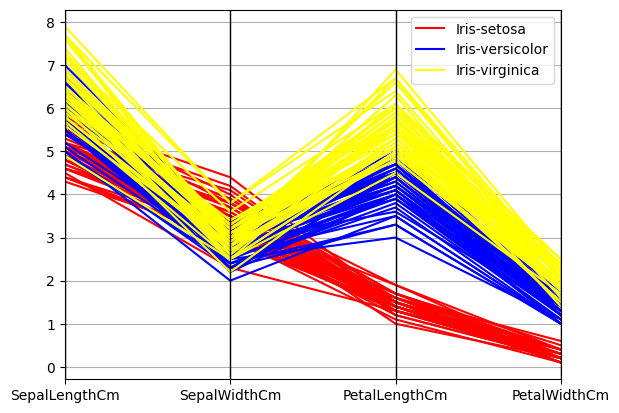

<Figure size 640x480 with 0 Axes>

In [7]:
# Load data from URL using Pandas
csv_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
col_names = ['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm','Species']
data =  pd.read_csv(csv_url, names = col_names)

#Do Parallel Plot
parallel_coordinates(data, 'Species', color=('#FF0000', '#0000FF', '#FFFF00'))
plt.figure()

# Display information about the dataset
print('=====================================================================================================')
print('First five rows in the dataset:\n', data.head(5))
print('=====================================================================================================')
print('Information about Data:')
print(data.info())

# Split dataset into input features and class labels
Y = data['Species']
X = data.drop(['Species'], axis=1)
print('=====================================================================================================')
print("Shape of Input  features: {}".format(X.shape))
print("Shape of Output features: {}".format(Y.shape))
print('=====================================================================================================')
print("Check the number of datapoints for each class label:")
print(Y.value_counts())

#One hot encode the class labels
lbl_clf = LabelEncoder()
Y_encoded = lbl_clf.fit_transform(Y)
Y_final = tensorflow.keras.utils.to_categorical(Y_encoded)
print('=====================================================================================================')
print("Therefore, our final shape of output feature will be {}".format(Y_final.shape))

## 1.2. Data Splitting and Normalization

From the dataset details, you can see that the IRIS dataset contains 150 samples. In the cell below, the data is split into two sets, with 75% of the samples for the training set and the remaining 25% for the test set.

Next, the input features are normalized using `StandardScaler` from scikit-learn. Normalization adjusts the feature values to have a mean of zero and a standard deviation of one, helping to improve the model's performance and training stability.

In [8]:
seed=42

#Split the dataset into train and test set using train_test_split() from sklearn
x_train, x_test, y_train, y_test = train_test_split(X, Y_final, test_size=0.25, random_state=seed, stratify=Y_encoded, shuffle=True)

#Normalize the dataset using StandardScaler() from sklearn
std_clf = StandardScaler()
x_train_std = std_clf.fit_transform(x_train)
x_test_std = std_clf.transform(x_test)

print("Training Input shape\t: {}".format(x_train_std.shape))
print("Testing Input shape\t: {}".format(x_test_std.shape))
print("Training Output shape\t: {}".format(y_train.shape))
print("Testing Output shape\t: {}".format(y_test.shape))

Training Input shape	: (112, 4)
Testing Input shape	: (38, 4)
Training Output shape	: (112, 3)
Testing Output shape	: (38, 3)


## 1.3. Defining the Neural Network Architecture

In the cell below, a neural network is defined using Keras. This architecture includes two hidden layers and is specifically designed to classify the IRIS dataset.

**Network Architecture:**

   1. **`First Hidden Layer:`** This layer has 10 neurons with ReLU activation, taking in the 4-dimensional input. Kernel is initialized with Normal distribution and uses L2 regularization (l2=0.01) to help reduce overfitting.

   2. **`Batch Normalization:`** Applied after the first hidden layer to standardize its output.

   3. **`Dropout Layer:`** 30% of the neurons are randomly dropped during training, which adds robustness by reducing reliance on specific neurons.

   4. **`Second Hidden Layer:`** This layer has 5 neurons, also using ReLU activation.  Kernel is initialized with Normal distribution and uses L2 regularization (l2=0.01) to help reduce overfitting. 

   5. **`Batch Normalization:`** Applied after the second hidden layer to standardize its output.
   
   6. **`Dropout Layer:`** 30% of the neurons are randomly dropped during training, which adds robustness by reducing reliance on specific neurons.
   
   7. **`Output Layer:`** This layer has 3 neurons, one for each class in the IRIS dataset, and uses Softmax activation to produce a probability distribution across the classes.

In [9]:
#Define the neural network architecture. Check Keras documentation for more info
import tensorflow
from tensorflow import keras

#Define a Sequential model
model = keras.models.Sequential(name="MLP-1")

#First Hidden Layer with 10 neurons that takes 4 dimensional input value and relu activation
model.add(keras.layers.Dense(10, input_dim=4, activation=tensorflow.nn.relu, kernel_initializer="normal",
                                kernel_regularizer=keras.regularizers.l2(0.01),
                                name="hidden_layer_1"))

#Apply Batch Normalization to the output values of the first hidden layer
model.add(keras.layers.BatchNormalization(name="batchnorm_1"))

#Adding Dropout to the first hidden layer with probability of 0.3
model.add(keras.layers.Dropout(0.3,name="dropout_1"))

#Second Hidden Layer with 5 neurons that takes 10 dimensional input value from previous layer and relu activation
model.add(keras.layers.Dense(5, activation = tensorflow.nn.relu, kernel_initializer="normal",
                                kernel_regularizer=keras.regularizers.l2(0.01),
                                name="hidden_layer_2"))

#Apply Batch Normalization to the output values of the second hidden layer
model.add(keras.layers.BatchNormalization(name="batchnorm_2"))

#Adding Dropout to the second hidden layer with probability of 0.3
model.add(keras.layers.Dropout(0.3, name="dropout_2"))

#Output Layer with Softmax activation
model.add(keras.layers.Dense(3, activation=tensorflow.nn.softmax,name="output_layer"))

#Once a model is "built", you can call its summary() method to display its contents
model.summary()

c:\Users\Marcus Sjöblom\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "MLP-1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 5)              │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183 (732.00 B)

 Trainable params: 153 (612.00 B)

 Non-trainable params: 30 (120.00 B)

## 1.4. Configuring and Training the Model

In the cell below, the model will be trained based on the following hyperparameters.

- **Optimizer:**  Adam optimizer

- **Loss Function:** categorical_crossentropy

- **Epochs:** 5

- **Batch Size:** 7

- **Metrics:** Accuracy

In [10]:
#Set seed
tensorflow.random.set_seed(42)

#Configure the model for training. Define the hyperparatmeters: optimizer, loss and metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Train the model
iris_model = model.fit(x_train_std, y_train, epochs=5, batch_size=7)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3232 - loss: 1.6292
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4649 - loss: 1.2298
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7218 - loss: 0.7027
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6689 - loss: 0.7391
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7320 - loss: 0.6517


## 1.5. Evaluation on Test set
In this cell, the trained model is evaluated on the test set and analyze its performance using key classification metrics.

In [11]:
from sklearn.metrics import classification_report

#Evaluate the model on test set
score = model.evaluate(x_test_std, y_test, verbose=0)

#Score has two values. The first value represent loss and the second value represent the accuracy
print("Test loss:      ", score[0])
print("Test accuracy:  ", 100*score[1])

#Get the model predictions on test set
y_pred = model.predict(x_test_std)
#Get the index of the highest value for each predictions (predicted class labels)
y_pred = np.argmax(y_pred, axis = 1)
#Convert the one hot vector to True class labels
y_test_oh = np.argmax(y_test, axis =1)

#Compute Precision, Recall, F1-Score and Accuracy of the model on the test set
print('=====================================================================================================')
print(classification_report(y_test_oh, y_pred, target_names=["Iris-setosa", "Iris-versicolor", "Iris-virginica"]))
print('=====================================================================================================')

Test loss:       1.0780214071273804
Test accuracy:   34.21052694320679
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
                 precision    recall  f1-score   support

    Iris-setosa       0.00      0.00      0.00        12
Iris-versicolor       0.34      1.00      0.51        13
 Iris-virginica       0.00      0.00      0.00        13

       accuracy                           0.34        38
      macro avg       0.11      0.33      0.17        38
   weighted avg       0.12      0.34      0.17        38



c:\Users\Marcus Sjöblom\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcus Sjöblom\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcus Sjöblom\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

## 2. Penguin Species Classifier

In this section, we will train a neural network to classify three penguin species based on the features: `bill length`, `bill depth`, `flipper length` and `body mass`. Here, you will do the step-by-step implementation of the classifier.


## Task 2.1: Loading data

For the dataset, we use Palmer Penguins dataset. The dataset consist of 344 datapoints with four input features : `bill length`, `bill depth`, `flipper length` and `body mass`. and three output classes `Adelie`, `Chinstrap` and `Gentoo`.

In the cell below, the Palmer Penguins dataset is loaded as a DataFrame. You will visualize the dataset using parallel-plot.

Length of the dataset:333

  species  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0  Adelie            39.1           18.7              181.0       3750.0
1  Adelie            39.5           17.4              186.0       3800.0
2  Adelie            40.3           18.0              195.0       3250.0
4  Adelie            36.7           19.3              193.0       3450.0
5  Adelie            39.3           20.6              190.0       3650.0


<Figure size 640x480 with 0 Axes>

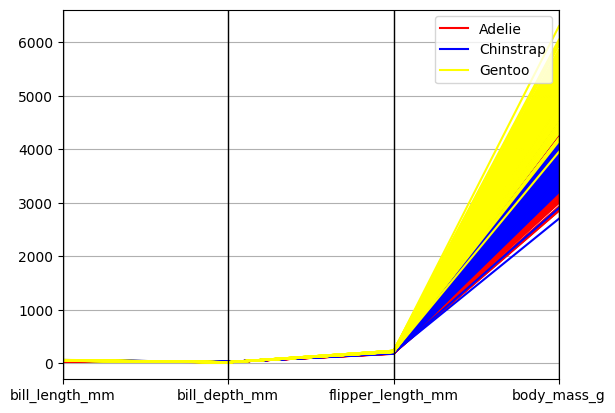

<Figure size 640x480 with 0 Axes>

In [17]:
import seaborn as sns

data = sns.load_dataset("penguins")

# Drop "NaN" values and column with text
data = data.dropna()
data = data.drop(columns=['island', 'sex'])

# Split dataset into input features and class labels
Y = data['species']
X = data.drop(['species'], axis=1)

#One hot encode the class labels
lbl_clf = LabelEncoder()
Y_encoded = lbl_clf.fit_transform(Y)
Y_final = tensorflow.keras.utils.to_categorical(Y_encoded)

print(f"Length of the dataset:{len(data)}\n")
print(data.head())

# Task 1: Do a parallel-plot of the data
parallel_coordinates(data, 'species', color=('#FF0000', '#0000FF', '#FFFF00'))
plt.figure()

## Task 2.2: Data Splitting and Normalization

From the dataset details, you can see that the Penguins dataset contains 333 samples (after removing "NaNs"). 

In the cell below, you will split the data, using 80% of the samples for the training set and the remaining 20% for the test set. Next, you will normalize the features using `StandardScaler` from scikit-learn.

In [14]:
seed=42

# Task 1: Split the dataset into train and test set using train_test_split() from sklearn
x_train, x_test, y_train, y_test = train_test_split(X, Y_final, test_size=0.20, random_state=seed, stratify=Y_encoded, shuffle=True)

# Task 2: Normalize the dataset using StandardScaler() from sklearn
std_clf = StandardScaler()
x_train_std = std_clf.fit_transform(x_train)
x_test_std = std_clf.transform(x_test)

print("Training Input shape\t: {}".format(x_train_std.shape))
print("Testing Input shape\t: {}".format(x_test_std.shape))
print("Training Output shape\t: {}".format(y_train.shape))
print("Testing Output shape\t: {}".format(y_test.shape))

Training Input shape	: (266, 4)
Testing Input shape	: (67, 4)
Training Output shape	: (266, 3)
Testing Output shape	: (67, 3)


## Task 2.3: Defining the Neural Network Architecture

In the cell below, you will define a neural network model using Keras. This architecture includes 3 hidden layers and is specifically designed to classify the IRIS dataset.

Design the network based on the following information:

   1. **`First Hidden Layer:`** This layer has 10 neurons with ReLU activation, taking in the 4-dimensional input. Kernel is initialized with He_Normal distribution and uses L2 regularization (l2=0.01) to help reduce overfitting.

   2. **`Batch Normalization:`** Applied after the first hidden layer to standardize its output.

   3. **`Dropout Layer:`** 25% of the neurons are randomly dropped during training, which adds robustness by reducing reliance on specific neurons.

   4. **`Second Hidden Layer:`** This layer has 10 neurons, also using ReLU activation.  Kernel is initialized with He_Normal distribution and uses L1L2 regularization (experiment with L1 and L2 values) to help reduce overfitting. 

   5. **`Batch Normalization:`** Applied after the second hidden layer to standardize its output.
   
   6. **`Dropout Layer:`** 25% of the neurons are randomly dropped during training, which adds robustness by reducing reliance on specific neurons.
   
   7. **`Third Hidden Layer:`** This layer has 8 neurons, also using ReLU activation.  Kernel is initialized with He_Normal distribution and uses L1L2 regularization (experiment with L1 and L2 values) to help reduce overfitting. 

   8. **`Batch Normalization:`** Applied after the third hidden layer to standardize its output.
   
   9. **`Dropout Layer:`** 25% of the neurons are randomly dropped during training, which adds robustness by reducing reliance on specific neurons.
   
   10. **`Fourth Hidden Layer:`** This layer has 8 neurons with ReLU activation, taking in the 4-dimensional input. Kernel is initialized with He_Normal distribution and uses L2 regularization (l2=0.01) to help reduce overfitting.

   11. **`Batch Normalization:`** Applied after the fourth hidden layer to standardize its output.

   12. **`Dropout Layer:`** 25% of the neurons are randomly dropped during training, which adds robustness by reducing reliance on specific neurons.
   
   13. **`Output Layer:`** This layer has 3 neurons, one for each class in the Penguins dataset, and uses Softmax activation to produce a probability distribution across the classes.

In [22]:
# Import necessary libraries
import tensorflow
from tensorflow import keras

# Define the Sequential model for the Penguin dataset
model = keras.models.Sequential(name="Penguin_Classifier")

# Task 1: Create a neural network architecture mentioned in the cell above.

#First Hidden Layer with 10 neurons that takes 4 dimensional input value and relu activation
model.add(keras.layers.Dense(10, input_dim=4, activation=tensorflow.nn.relu, kernel_initializer="he_normal",
                                kernel_regularizer=keras.regularizers.l2(0.01),
                                name="hidden_layer_1"))

#Apply Batch Normalization to the output values of the first hidden layer
model.add(keras.layers.BatchNormalization(name="batchnorm_1"))

#Adding Dropout to the first hidden layer with probability of 0.25
model.add(keras.layers.Dropout(0.25,name="dropout_1"))

#Second Hidden Layer with 10 neurons that takes 10 dimensional input value from previous layer and relu activation
model.add(keras.layers.Dense(10, activation = tensorflow.nn.relu, kernel_initializer="he_normal",
                                kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
                                name="hidden_layer_2"))

#Apply Batch Normalization to the output values of the second hidden layer
model.add(keras.layers.BatchNormalization(name="batchnorm_2"))

#Adding Dropout to the second hidden layer with probability of 0.25
model.add(keras.layers.Dropout(0.25, name="dropout_2"))

#Third Hidden Layer with 8 neurons that takes 10 dimensional input value from previous layer and relu activation
model.add(keras.layers.Dense(8, activation = tensorflow.nn.relu, kernel_initializer="he_normal",
                                kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
                                name="hidden_layer_3"))

#Apply Batch Normalization to the output values of the third hidden layer
model.add(keras.layers.BatchNormalization(name="batchnorm_3"))

#Adding Dropout to the third hidden layer with probability of 0.25
model.add(keras.layers.Dropout(0.25, name="dropout_3"))

#Fourth Hidden Layer with 8 neurons that takes 8 dimensional input value from previous layer and relu activation
model.add(keras.layers.Dense(8,input_dim=4, activation = tensorflow.nn.relu, kernel_initializer="he_normal",
                                kernel_regularizer=keras.regularizers.l2(0.01),
                                name="hidden_layer_4"))

#Apply Batch Normalization to the output values of the fourth hidden layer
model.add(keras.layers.BatchNormalization(name="batchnorm_4"))

#Adding Dropout to the fourth hidden layer with probability of 0.25
model.add(keras.layers.Dropout(0.25, name="dropout_4"))

#Output Layer with Softmax activation
model.add(keras.layers.Dense(3, activation=tensorflow.nn.softmax,name="output_layer"))

# Display the model summary
model.summary()


Model: "Penguin_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_4 (Dense)          │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 419 (1.64 KB)

 Non-trainable params: 72 (288.00 B)

## Task 2.4: Configuring and Training the Model

In the cell below, we will configure the neural network model for training based on the following hyperparameters.

- **Optimizer:**  AdamW optimizer

- **Loss Function:** categorical_crossentropy

- **Epochs:** 20

- **Batch Size:** 16

- **Metrics:** F1 Score

In [39]:
#Set seed
tensorflow.random.set_seed(42)

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# Task 1: Configure the model for training. Define the hyperparatmeters: optimizer, loss and metrics
model.compile(optimizer='adamW', loss='categorical_crossentropy', metrics=['f1_score'])

# Task 2: Train the model
penguin_model = model.fit(x_train_std, y_train, epochs=20, batch_size=16, callbacks=[callback])



Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - f1_score: 0.8315 - loss: 0.7073
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.8679 - loss: 0.6518 
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.9235 - loss: 0.6426 
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.9399 - loss: 0.6020
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.9293 - loss: 0.5878 
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.9421 - loss: 0.5735 
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.9124 - loss: 0.6402
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.9038 - loss: 0.5785
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.9237 - loss: 0.5566 
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.9082 - loss: 0.5624 
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.9282 - loss: 0.5362
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.934

## Task 2.5: Plot Loss Curve

Visualize the training loss from the above training process using `matplotlib`. The training data can be accessed through `penguin_model.history`.

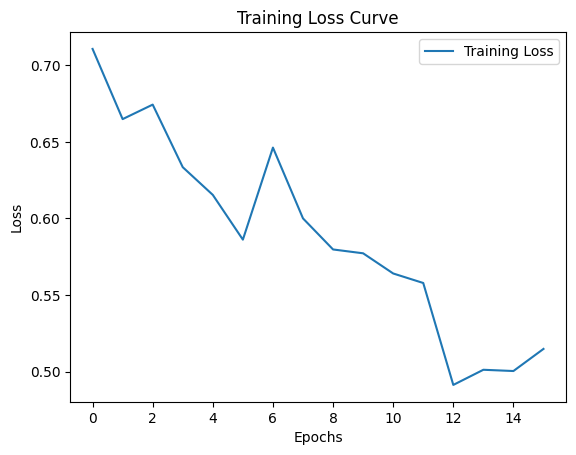

In [40]:
import matplotlib.pyplot as plt

# Task 1: Plot the training loss curve

# Assuming `penguin_model` is a trained Keras model and contains a `history` object
history = penguin_model.history

# Plot the training loss curve
plt.plot(history['loss'], label='Training Loss')

# Optional: Add validation loss if it exists
if 'val_loss' in history:
    plt.plot(history['val_loss'], label='Validation Loss')

plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Task 2.6: Evaluation on Test set

In this cell, you will find the `Precision`, `Recall` and `F1-score` of the model on the test set.

In [41]:
from sklearn.metrics import classification_report

# Task 1: Compute the precision, recall and F1-score of the trained model on test set

#Evaluate the model on test set
score = model.evaluate(x_test_std, y_test, verbose=0)

#Score has two values. The first value represent loss and the second value represent the accuracy
print("Test loss:      ", score[0])
print("Test accuracy:  ", 100*score[1])

#Get the model predictions on test set
y_pred = model.predict(x_test_std)
#Get the index of the highest value for each predictions (predicted class labels)
y_pred = np.argmax(y_pred, axis = 1)
#Convert the one hot vector to True class labels
y_test_oh = np.argmax(y_test, axis =1)

#Compute Precision, Recall, F1-Score and Accuracy of the model on the test set
print('=====================================================================================================')
print(classification_report(y_test_oh, y_pred, target_names=["Adelie", "Chinstrap", "Gentoo"]))
print('=====================================================================================================')

Test loss:       0.36325398087501526
Test accuracy:   tf.Tensor([ 98.245605  96.55172  100.      ], shape=(3,), dtype=float32)
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        29
   Chinstrap       0.93      1.00      0.97        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           0.99        67
   macro avg       0.98      0.99      0.98        67
weighted avg       0.99      0.99      0.99        67



# 3. Live Plot and Predictions 

In this task, we will visualize the train and test accuracy along with the test set predictions after every batch in an epoch using live plot.

## 3.1. Helper Function for Plotting

In [42]:
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
import random

def imgrid(x,y,yp,xx,yy):
    ind = [i for i in range(x.shape[0])]
    random.shuffle(ind)

    plt.figure(figsize=(18,yy*2))
    for i in range(xx*yy):
        plt.subplot(yy,xx,i+1)
        if x.shape[3]==1:
            plt.imshow(x[ind[i],:,:,0],cmap='gray')
        else:
            plt.imshow(x[ind[i],:,:,:])

        if len(yp)>0:
            plt.title('p=%d, gt=%d'%(yp[ind[i]],y[ind[i]]))
        else:
            plt.title('label=%d'%(y[ind[i]]))
        plt.axis('off')
    plt.show()

def live_plot(x, y, yp, acc, acc_test, batch, bs, N, xx, yy):
    clear_output(wait=True)

    ind = [i for i in range(x.shape[0])]

    fig = plt.figure(figsize=(18, 10))
    outer = gridspec.GridSpec(2, 1, hspace=0.2)
    inner = gridspec.GridSpecFromSubplotSpec(yy, xx,
                    subplot_spec=outer[0], wspace=0.1, hspace=0.0)

    for i in range(xx*yy):
        ax = plt.Subplot(fig, inner[i])
        if x.shape[3]==1:
            ax.imshow(x[ind[i],:,:,0],cmap='gray')
        else:
            ax.imshow(x[ind[i],:,:,:])
        if yp[ind[i]] == y[ind[i]]:
            ax.set_title('Pred = %d'%(yp[ind[i]]), color='g')
        else:
            ax.set_title('Pred = %d'%(yp[ind[i]]), color='r')
        ax.axis('off')
        fig.add_subplot(ax)

    inner = gridspec.GridSpecFromSubplotSpec(1, 1,
                    subplot_spec=outer[1], wspace=0.0, hspace=0.1)
    ax = plt.Subplot(fig, inner[0])
    ax.plot(np.linspace(0,batch*bs/N,len(acc)),100.0*np.array(acc),label='Training')
    ax.plot(np.linspace(0,batch*bs/N,len(acc_test)),100.0*np.array(acc_test),label='Test')
    ax.plot(batch*bs/N,100*acc[-1],'o')
    ax.plot(batch*bs/N,100*acc_test[-1],'o')
    ax.legend()
    ax.grid(1)
    ax.set_xlim([0,np.maximum(1,batch*bs/N)])
    ax.set_ylim([np.minimum(np.min(100.0*np.array(acc)),np.min(100.0*np.array(acc_test))),100])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    fig.add_subplot(ax)

    plt.show()

class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.l_train = []
        self.l_test = []
        self.bs = 128
        self.batch = 0

    def on_train_batch_end(self, batch, logs=None):
        self.l_train.append(logs['accuracy'])
        self.batch += 1

        if np.mod(batch,10)==0:
            score = model.evaluate(x_test, y_test, verbose=0)
            self.l_test.append(score[1])

            yp_test = np.argmax(model.predict(x_test[:24]),1)
            live_plot(x_test,np.argmax(y_test[:24],1),yp_test,self.l_train,self.l_test,self.batch,self.bs,len(x_train)-self.bs,12,2)

## 3.2. Load MNIST Data

The MNIST dataset is a collection of handwritten digits, consisting of 60,000 training images and 10,000 test images, each 28x28 pixels in grayscale. It is commonly used for training and evaluating machine learning models, particularly for image classification tasks.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


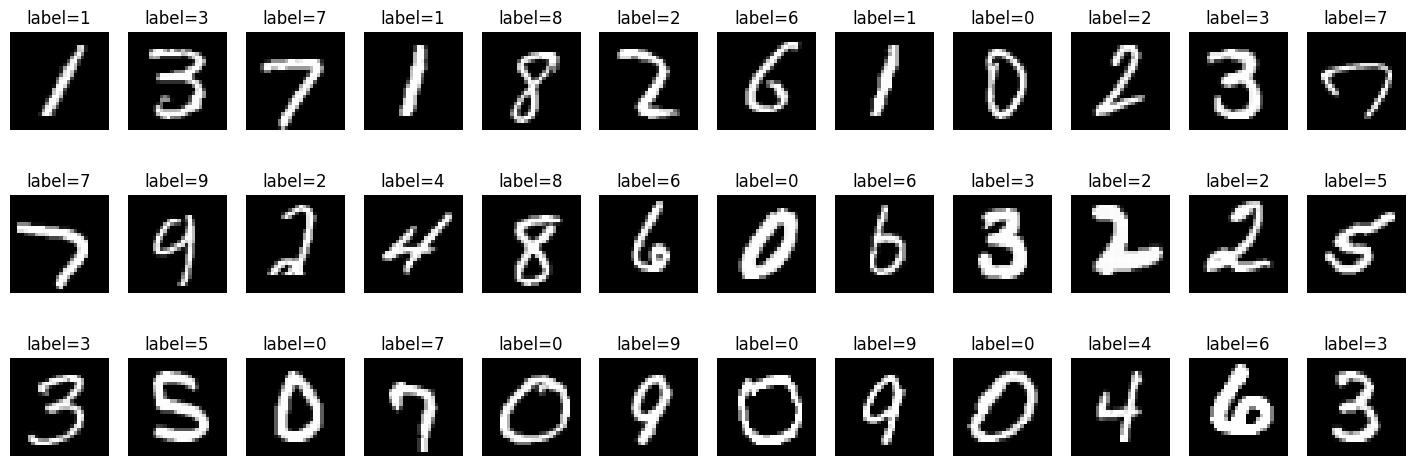

In [43]:
import numpy as np
import keras

# load MNIST dataset from keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# One hot encoding of class labels
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Display images
imgrid(x_train,np.argmax(y_train,1),[],12,3)

## 3.3. Model Definition and Training

We will define Convolutional Neural Networks for this task, which will be covered in the lab 2 and the next teaching session.

In [44]:
import tensorflow
from tensorflow import keras
from keras import layers

keras.backend.clear_session()

#Define model architecture
model = keras.Sequential(
      [
          layers.InputLayer(input_shape=(28,28,1)),
          layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),
          layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
          layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Flatten(),
          layers.Dense(128, activation="relu"),
          layers.Dense(10, activation="softmax"),
      ])

model.summary()

c:\Users\Marcus Sjöblom\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 32)     │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,202 (309.38 KB)

 Trainable params: 79,202 (309.38 KB)

 Non-trainable params: 0 (0.00 B)

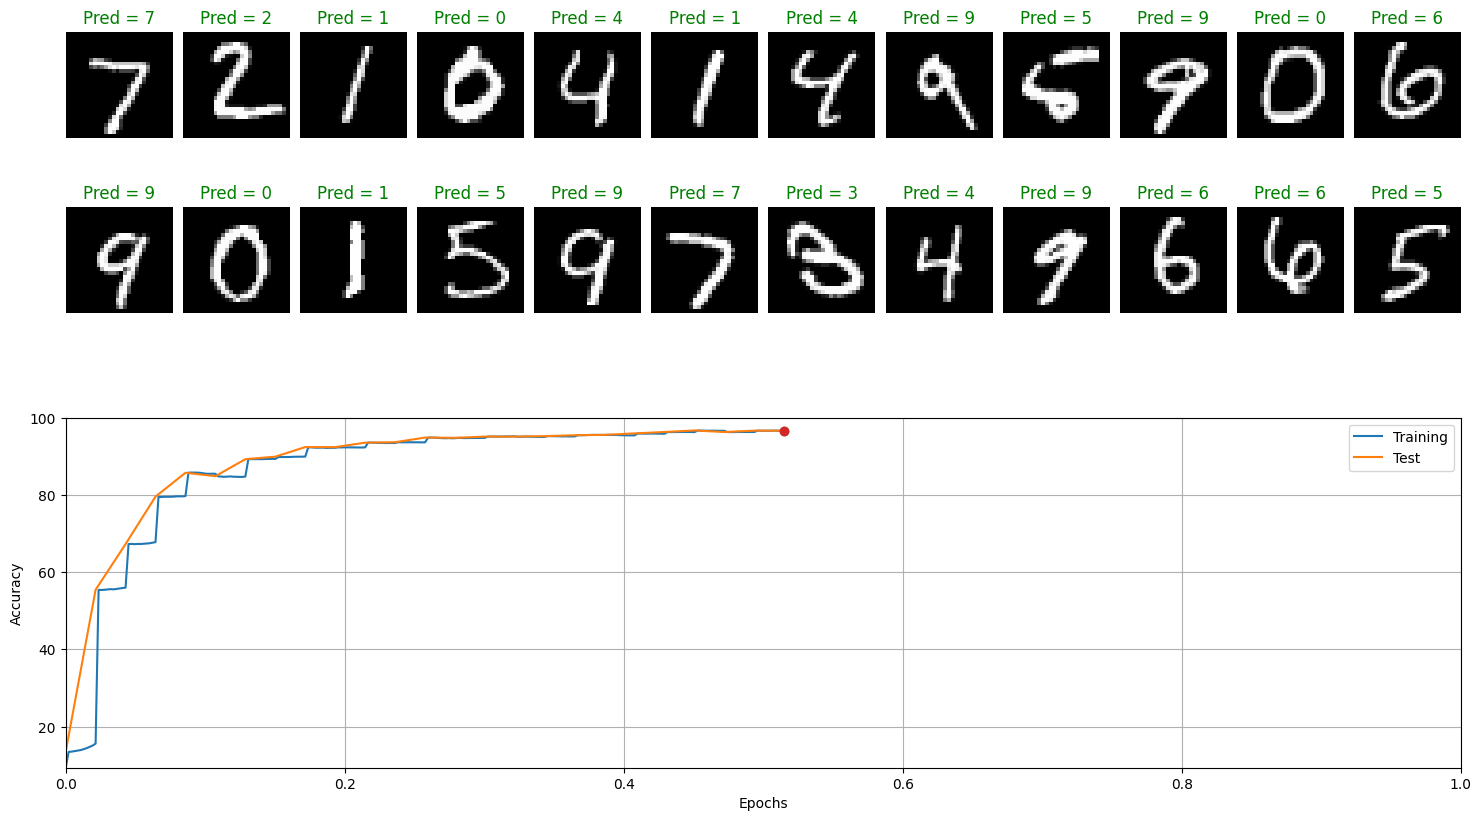

KeyboardInterrupt: 

In [46]:
opt = keras.optimizers.Adam()

#Configure the model for training
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

#Train the model for 1 Epoch
model.fit(x_train, y_train, batch_size=128, epochs=1,
          callbacks=[CustomCallback()],
          validation_split=0.0, verbose=0);

## 3.4. Evaluation

In [47]:
#Displaying the training performance
score = model.evaluate(x_train, y_train, verbose=0)
print("Train loss:     ", score[0])
print("Train accuracy: ", 100*score[1])

#Displaying the test performance
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:      ", score[0])
print("Test accuracy:  ", 100*score[1])

Train loss:      0.11526725441217422
Train accuracy:  96.49666547775269
Test loss:       0.10321970283985138
Test accuracy:   96.64000272750854
